# Simulated MVB

参考论文：<br>
https://www.researchgate.net/publication/6135459_Adaptive_Beamforming_Applied_to_Medical_Ultrasound_Imaging <br>
https://iopscience.iop.org/article/10.1088/1681-7575/aad146

### 1. 读取模拟钟组数据

In [1]:
import numpy as np
with open('simulated_data.npy', 'rb') as f:
    simulated_data = np.load(f)

In [2]:
print("Data shape: " + str(simulated_data.shape))  # 5 * (86400 * 30 -1)
print(simulated_data[0,:])

Data shape: (5, 2591999)
[ 9.37845159e-14 -6.07258459e-14  1.48330715e-13 ...  9.11494279e-14
 -4.01285019e-14  1.03910840e-13]


### 2. 使用MVB合成钟组

In [3]:
# https://allantools.readthedocs.io/en/latest/functions.html
!pip install allantools
import allantools

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
y_t = simulated_data.T

In [5]:
subset_size = 3
clock_size = y_t.shape[1]

if subset_size > clock_size:
    raise Exception('The subset size should not be greater than the number of clocks')

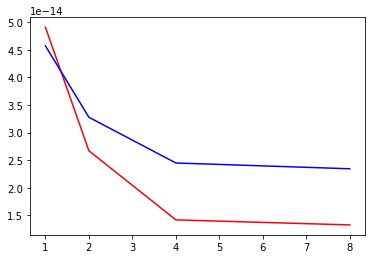

172800 86400


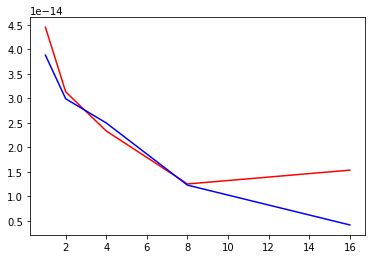

72000 36000


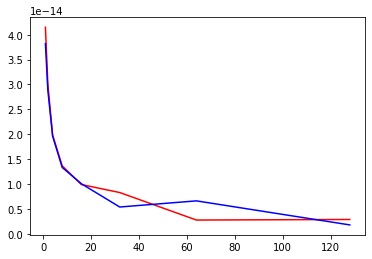

18000 3600


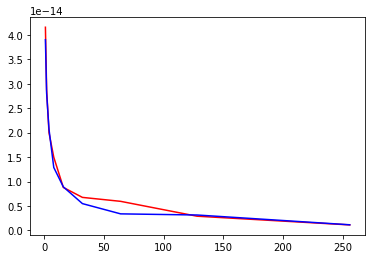

9000 1800


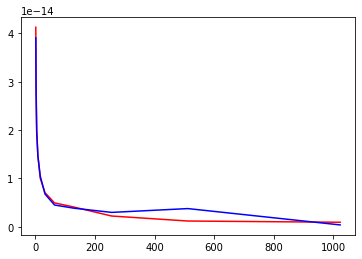

6000 600


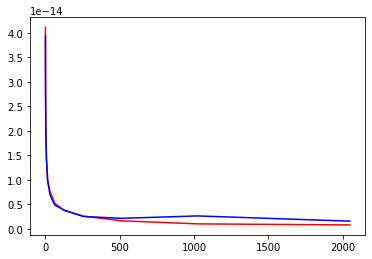

3000 300
Done


In [6]:
window_step_list = [60*60*24, 60*60*10, 60*60, 60*30, 60*10, 60*5]
amplify = [2, 2, 5, 5, 10, 10]
window_size_list = [x*y for (x,y) in zip(window_step_list, amplify)]

import sys
regularization = True
A = np.ones((clock_size - subset_size + 1, 1))

# 0. For each (window_size, window_step) combination
for window_size, window_step in zip(window_size_list, window_step_list):
    savedStdout = sys.stdout
    if window_size > y_t.shape[0]:
        raise Exception('The window size should not be greater than the number of time points')

    with open('%s_%s.txt' % (window_size, window_step), 'w+') as file:
        sys.stdout = file
        weighted_clock_estimation = list()
        weighted_inverse_variance_estimation = list()
        for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
            subset_raw_sum_list = list()
            print("------------------Step %s------------------" % i)
            for j in range(y_t.shape[1] - subset_size + 1):
                # 1. Get raw subset
                subset_raw = y_t[i:i+window_size,j:j+subset_size]
        
                # 2. Calculate summation within a subset 
                subset_raw_sum = np.sum(subset_raw, axis=1)
                subset_raw_sum_list.append(subset_raw_sum)
                print("*** Raw sum ***")
                print(subset_raw_sum) 

            # 3. Calculate covariance matrix mean (Element-wise)
            print("*** Cov mean ***")
            allset_cov_mean = np.cov(np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1)
            print(allset_cov_mean)
            print("*** Corr ***")
            allset_corr_mean = np.corrcoef(np.asarray(subset_raw_sum_list))
            print(allset_corr_mean)
    
            # 4. Add regularization term
            if regularization:
                print("*** Regularization term ***")
                sigma = np.max(allset_cov_mean) / (clock_size * 10.0)
                print(sigma * np.eye(clock_size - subset_size + 1))
                allset_cov_mean += sigma * np.eye(clock_size - subset_size + 1)
    
    
            # 5. Calculate the inverse of covariance matrix mean
            print("*** Inverse Cov mean ***")
            allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
            print(allset_cov_mean_inverse)
    
            # 6. Calculate weight
            print("*** Weight ***")
            weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
            print(weight)

            # 7. Calculate beamformer weighted clock
            print("*** Weighted output ***")
            Z = (np.dot(weight.T, np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1))[0]
            print(Z)
    
            # 8. Select the last element in Z as the estimation of weighted clock
            weighted_clock_estimation.append(Z[-1])
    
            # 9. Calculate allan variance for each clock
            inverse_variance = list()
            clock_last_row = list()
            for k in range(clock_size):
                clock = y_t[window_step * i:window_step * i + window_size + 1, k]
                (taus, adevs, errors, ns) = allantools.adev(data=clock, data_type='freq')
                inverse_variance.append(1.0 / adevs[0])
                clock_last_row.append(clock[-1])
            inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
            print("*** Inverse variance weight ***")
            print(inverse_variance)
    
            # 10. Calculate the inverse variance weighted clock
            weighted_inverse_variance_clock = np.dot(inverse_variance, np.array(clock_last_row))
            print("*** Inverse variance weighted clock ***")
            print(weighted_inverse_variance_clock)
            weighted_inverse_variance_estimation.append(weighted_inverse_variance_clock)
    
        # 11. Visualize weighted clock estimation and each clock
        print("------------------Overall------------------")
        print("*** Weighted clock estimation ***")
        print(weighted_clock_estimation)

        print("*** Inverse variance weighted clock estimation ***")
        print(weighted_inverse_variance_estimation)

        real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
        real_clock_mean = np.mean(real_clock, axis=1)
        print("*** Mean clock estimation ***")
        print(real_clock_mean)

        print("*** Clock covariance matrix ***")
        print(np.cov(real_clock.T))

        print("*** Clock corr matrix ***")
        print(np.corrcoef(real_clock.T))

        # 12. Calculate Allan variance
        fig = plt.figure(facecolor='white')
        
        print("*** Weighted clock's Allan Variance ***")
        (taus, adevs, errors, ns) = allantools.adev(data=weighted_clock_estimation, data_type='freq')
        print('taus - %s, adevs - %s' % (taus, adevs))
        plt.plot(taus, adevs, color='red')

        print("*** Mean clock's Allan Variance ***")
        (taus, adevs, errors, ns) = allantools.adev(data=real_clock_mean, data_type='freq')
        print('taus - %s, adevs - %s' % (taus, adevs))

        print("*** Inverse variance weighted clock's Allan Variance ***")
        (taus, adevs, errors, ns) = allantools.adev(data=weighted_inverse_variance_estimation, data_type='freq')
        print('taus - %s, adevs - %s' % (taus, adevs))
        plt.plot(taus, adevs, color='blue')

        print("*** Each clock's Allan Variance ***")
        for i in range(real_clock.shape[1]):
            (taus, adevs, errors, ns) = allantools.adev(data=real_clock[:,i], data_type='freq')
            print('taus - %s, adevs - %s' % (taus, adevs))
            
        plt.show()
        sys.stdout = savedStdout
        print(window_size, window_step)

print('Done')